# Model training

In this file, I want to build and train some models and select the best predictor of ace/no ace.

## Importing libraries

In [1]:
# Import everything from my_libraries.py
from my_libraries import *  # noqa: F403

# Other utilities
import tennis_utils
import dataframe_utils

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-02-27 13:51:53.419343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)

In [3]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("datasets/train_dataset.csv")

In [6]:
# Impute missing values and feature engineer
X_train, X_test = [dataframe_utils.impute_data(df) for df in (X_train, X_test)]
X_train, X_test = [dataframe_utils.feature_engineer(df) for df in (X_train, X_test)]

In [7]:
X_train

,bin_mean_ball_hit_y,ball_bounce_y,receiver_y,ball_hit_x,ball_net_z,ball_bounce_x,ball_bounce_angle,hitter_x,receiver_x,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,bin_mean_speed,bin_mean_ball_hit_z,surface_clay,surface_hard,hitter_hand_left,receiver_hand_left,serve_number,close_to_side_line,close_to_center_line,close_to_service_line
0,0.829585,-0.168997,-0.902120,0.178764,-1.483581,-0.687501,0.142768,1.134956,0.911763,1.183361,1.076071,0.112884,-0.353871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.535732,0.279581,0.113482,1.810995,0.242343,0.912734,-0.835339,0.929693,0.973754,0.459598,0.690109,1.346496,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.267366,-0.219920,-0.678570,1.642724,0.198089,1.024628,-0.645843,0.450747,1.398830,0.800148,-0.404254,0.994036,-0.353871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.355822,0.842736,0.098187,0.100238,0.242343,0.345601,0.184168,0.318792,0.031017,-0.139920,-1.213970,0.465345,0.600041,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.355822,0.014978,0.051347,0.952812,-0.819764,-1.361930,0.446028,-0.619551,1.287731,1.862216,1.176582,-0.415807,-0.353871,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,0.644178,-0.110334,-0.905124,-0.045597,-0.722404,0.391584,-1.138599,-0.775942,-0.093768,-0.278386,1.282722,1.515677,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
115034,0.644178,-0.796805,-0.915776,0.330208,0.260045,0.396183,0.039774,-1.235339,-0.273299,-0.447538,-0.865800,-0.063346,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
115035,-0.535732,0.145282,0.167423,1.766123,-0.625044,-0.098909,-0.439182,1.682323,0.951212,0.932626,1.440323,-0.415807,-1.297526,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
115036,0.829585,-0.314778,-0.909085,0.408735,-1.288861,-0.371746,-0.526693,0.949242,-0.607402,-0.383170,0.647493,0.994036,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Imbalanced dataset

Almost 92% of serves are not aces. The data is highly imbalanced. For the machine learning model to learn effectively, the data has to be balanced. I am using the random oversampler for this. Note that there are not too many unique ways you can serve an ace. ie: high serve speed, aim at the lines, hit where your opponent doesn't expect you to but this will still be to the leftmost or rightmost of the ad/deuce court.

In [8]:
y_train.value_counts()

is_ace
0    105993
1      9045
Name: count, dtype: int64

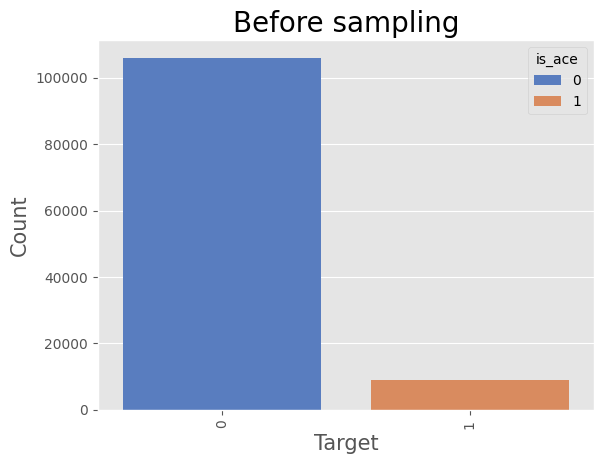

In [9]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("Before sampling", fontsize=20)
plt.show()

In [ ]:
# # Random oversampling to make the majority and minority class even

# rd_over_sample = RandomOverSampler()
# X_train, y_train = rd_over_sample.fit_resample(X_train, y_train)

In [11]:
# SMOTE sampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

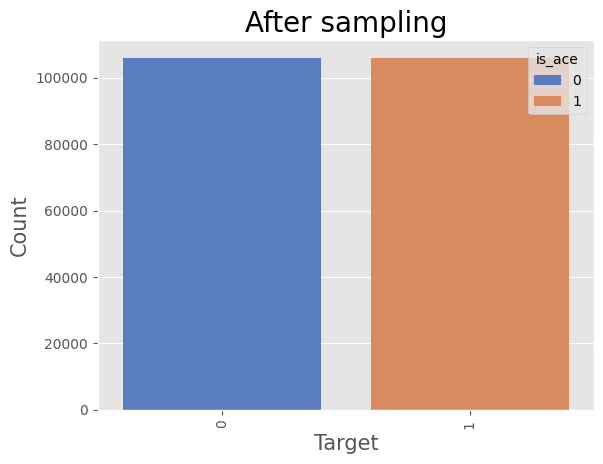

In [12]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("After sampling", fontsize=20)
plt.show()

# Models

In [16]:
def scoring():
    """A function to print scores and save them in lists."""
    print("\n-----Train Data Accuracy----")
    a_s = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_train.to_numpy(), y_pred_train), 4)
    print("F1 score:", f_1)
    accuracy_train.append(a_s)
    F1score_train.append(f_1)

    print("-----Test Data Accuracy----")
    a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_test.to_numpy(), y_pred), 4)
    print("F1 score:", f_1)
    accuracy_test.append(a_s)
    F1score_test.append(f_1)

In [14]:
# Saving model scores in list for final evaluation
accuracy_test = []
accuracy_train = []
F1score_test = []
F1score_train = []

## Random Forest Classifer

In [15]:
# Got the best split from the GridSearchCV below
rfc = RandomForestClassifier(
    random_state=42, max_depth=10, n_estimators=50, min_samples_split=6
)

# Training Model
rfc.fit(X_train, y_train)
# Save model
joblib.dump(rfc, "rfc_model.joblib")
# Load model
saved_model = joblib.load("rfc_model.joblib")
# Predict
y_pred = saved_model.predict(X_test)
y_pred_train = saved_model.predict(X_train)

In [17]:
scoring()


-----Train Data Accuracy----
Accuracy score: 0.92
F1 score: 0.9213
-----Test Data Accuracy----
Accuracy score: 0.8799
F1 score: 0.5208


### Using gridsearch cv for hyper parameter tuning

In [18]:
param_grid = [
    {
        "n_estimators": [20, 50],
        "max_depth": [5, 7, 10],
        "min_samples_split": [2, 3, 6],
    }
]

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=2,
    return_train_score=True,
    verbose=True,
)
grid_search.fit(X_train, y_train)

# Save the model so you don't have to run Gridsearchcv again.
# Access the best model
best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best model to a file using joblib
joblib.dump(best_model, "best_random_forest_model.joblib")

# Grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores.
# Converting that to a df and saving as a csv so it can be accessed whenever.

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.to_csv("cv_results.csv")

Fitting 2 folds for each of 18 candidates, totalling 36 fits


Obtaining the top ten most important features.

In [19]:
# Extract feature importances
importances = saved_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
)

# Sort features by importance
top_features = feature_importance_df.sort_values(by="Importance", ascending=False).head(
    10
)

# Display the top 10 features
print("Top 10 Features for Serve Prediction:")
print(top_features)

Top 10 Features for Serve Prediction:
                          Feature  Importance
19           close_to_center_line    0.150180
11                 bin_mean_speed    0.144625
10  dist_ball_bounce_y_returner_y    0.142201
1                   ball_bounce_y    0.133017
18             close_to_side_line    0.125864
6               ball_bounce_angle    0.082023
17                   serve_number    0.066470
0             bin_mean_ball_hit_y    0.034804
4                      ball_net_z    0.023597
8                      receiver_x    0.017853


Three of new features engineered have made it into the top 10, two making it to top 3.

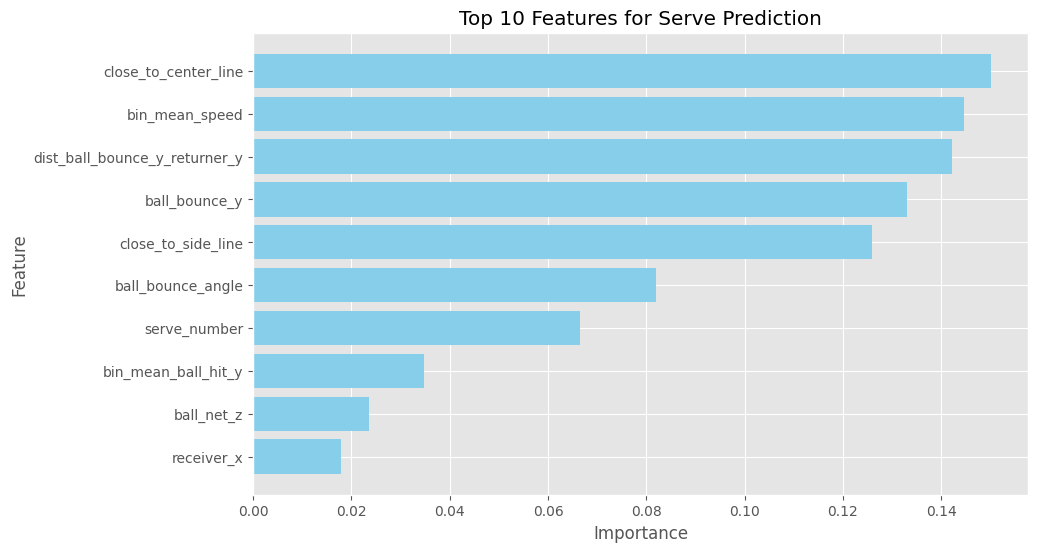

In [20]:
# Visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features for Serve Prediction")
plt.gca().invert_yaxis()
plt.show()

In [21]:
# Sort features by importance
worst_features = feature_importance_df.sort_values(
    by="Importance", ascending=True
).head(10)

# Display the top 10 features
print("Worst 10 Features for Serve Prediction:")
print(worst_features)

Worst 10 Features for Serve Prediction:
                          Feature  Importance
16             receiver_hand_left    0.001288
20          close_to_service_line    0.001589
7                        hitter_x    0.002305
15               hitter_hand_left    0.002469
14                   surface_hard    0.008138
12            bin_mean_ball_hit_z    0.008566
3                      ball_hit_x    0.009161
13                   surface_clay    0.009437
2                      receiver_y    0.010573
9   dist_ball_bounce_x_returner_x    0.010862


Dropping more columns

In [ ]:
# new_columns_to_drop = ['receiver_hand_left', 'surface_hard', 'close_to_service_line','hitter_hand_left','serve_side_deuce','hitter_x']
# X_train.drop(columns=new_columns_to_drop, inplace=True)
# X_test.drop(columns=new_columns_to_drop, inplace=True)

### XG Boost

In [22]:
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=1,
    colsample_bytree=0.85,
    subsample=0.85,
    learning_rate=0.05,
    n_estimators=100,
    max_depth=4,
)

# Training Model
xgb.fit(X_train, y_train)

# Mode summary
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

scoring()


-----Train Data Accuracy----
Accuracy score: 0.9215
F1 score: 0.9228
-----Test Data Accuracy----
Accuracy score: 0.8744
F1 score: 0.5085


In [23]:
joblib.dump(xgb, "xgb_model.joblib")

['xgb_model.joblib']

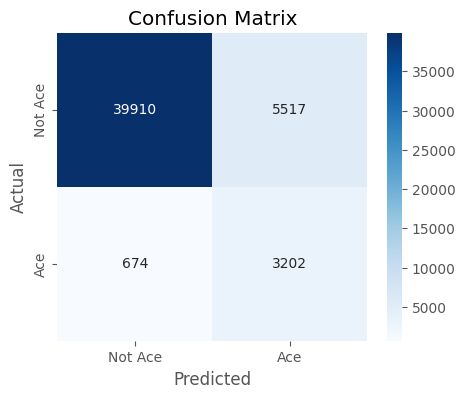

In [24]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Ace", "Ace"],
    yticklabels=["Not Ace", "Ace"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

More focus must be given to identifying why serves that are not aces are getting identified as aces.